# Debiasing with Orthogonalization: FWL Refresher

## Table of Contents
1. [Intuition](#intuition)
2. [Formal Treatment](#formal)
3. [Numeric Demonstration](#numeric)
4. [Implementation](#implementation)
5. [Interview Appendix](#interview)
6. [References](#references)

---

**Appendix A2 | Notebook 1 of 3**

The Frisch-Waugh-Lovell theorem is the foundation for modern causal ML.
This notebook reviews the theorem and its geometric interpretation.

In [1]:
# Standard imports
import sys
from pathlib import Path

# Add parent to path for imports
module_path = str(Path.cwd().parent.parent)
if module_path not in sys.path:
    sys.path.insert(0, module_path)

from facure_augment.common import *
set_notebook_style()

import statsmodels.formula.api as smf

---

## 1. Intuition {#intuition}

### Linear Regression Reborn

The Frisch-Waugh-Lovell (FWL) theorem, discovered in 1933, reveals the inner
workings of linear regression. It states:

> You can decompose any multivariate regression into three stages,
> and get the **same** coefficient estimates.

### Why This Matters for Causal Inference

FWL shows that regression estimates a coefficient by:
1. **Debiasing**: Removing confounding variation from the treatment
2. **Denoising**: Removing extraneous variation from the outcome
3. **Estimating**: Regressing the "clean" outcome on the "clean" treatment

This is exactly what we need for causal inference from observational data!

### The Core Insight

Each regression coefficient answers:
> "How much does Y change when I increase X, **holding all else fixed**?"

FWL reveals HOW regression achieves this "holding fixed" operation.

---

## 2. Formal Treatment {#formal}

### 2.1 The FWL Theorem

**Setup**: Partition features into two sets $X_1$ and $X_2$.

Full regression:
$$Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \epsilon$$

**Theorem**: The coefficient $\hat{\beta}_2$ from the full regression equals
the coefficient from the following three-stage procedure:

**Stage 1** (Denoise Y):
$$Y = \theta_0 + \theta_1 X_1 + e_Y$$
$$Y^* = Y - (\hat{\theta}_0 + \hat{\theta}_1 X_1)$$

**Stage 2** (Debias X₂):
$$X_2 = \gamma_0 + \gamma_1 X_1 + e_X$$
$$X_2^* = X_2 - (\hat{\gamma}_0 + \hat{\gamma}_1 X_1)$$

**Stage 3** (Estimate):
$$Y^* = \alpha_0 + \beta_2 X_2^* + \epsilon$$

**Result**: $\hat{\beta}_2^{\text{FWL}} = \hat{\beta}_2^{\text{Full}}$

### 2.2 The Residual Maker Matrix

Define the residual maker (annihilator):
$$M_1 = I - X_1(X_1'X_1)^{-1}X_1'$$

This matrix "projects out" $X_1$ from any vector:
- $M_1 Y$ gives residuals of regressing $Y$ on $X_1$
- $M_1 X_2$ gives residuals of regressing $X_2$ on $X_1$

**FWL in matrix form**:
$$\hat{\beta}_2 = (X_2' M_1 X_2)^{-1} X_2' M_1 Y$$

### 2.3 Causal Interpretation

For causal inference, let:
- $X_2 = T$ (treatment)
- $X_1 = X$ (confounders)

Then FWL says:
$$\hat{\tau} = \frac{\text{Cov}(\tilde{Y}, \tilde{T})}{\text{Var}(\tilde{T})}$$

where:
- $\tilde{Y} = Y - E[Y|X]$ (outcome residual)
- $\tilde{T} = T - E[T|X]$ (treatment residual)

**Key insight**: $\tilde{T}$ is the "as-if-random" variation in treatment.

---

## 3. Numeric Demonstration {#numeric}

### Ice Cream Pricing Example

In [2]:
# Load ice cream data
prices = load_facure_data("ice_cream_sales.csv")
print(f"Data shape: {prices.shape}")
prices.head()

Data shape: (10000, 5)


,temp,weekday,cost,price,sales
0,17.3000,6,1.5000,5.6000,173
1,25.4000,3,0.3000,4.9000,196
2,23.3000,5,1.5000,7.6000,207
3,26.9000,1,0.3000,5.3000,241
4,20.2000,1,1.0000,7.2000,227


In [3]:
# Check correlations - note positive price-sales correlation (confounded!)
print("Correlation matrix:")
print(prices.corr().round(3))

print("\n⚠️  Price-sales correlation is POSITIVE (0.080)!")
print("   This makes no economic sense - clearly confounded.")

Correlation matrix:
           temp  weekday    cost   price   sales
temp     1.0000  -0.0060  0.0000 -0.0040  0.3760
weekday -0.0060   1.0000  0.0090  0.0050  0.0120
cost     0.0000   0.0090  1.0000  0.3900 -0.0150
price   -0.0040   0.0050  0.3900  1.0000  0.0760
sales    0.3760   0.0120 -0.0150  0.0760  1.0000

⚠️  Price-sales correlation is POSITIVE (0.080)!
   This makes no economic sense - clearly confounded.


### Full Regression vs FWL Decomposition

In [4]:
# Method 1: Full regression
full_model = smf.ols("sales ~ price + cost + temp + C(weekday)", data=prices).fit()
beta_price_full = full_model.params['price']

print("Full Regression Coefficient on Price:")
print(f"  β_price = {beta_price_full:.6f}")

Full Regression Coefficient on Price:
  β_price = -4.000429


In [5]:
# Method 2: FWL three-stage procedure

# Stage 1: Regress Y on confounders, get residuals
model_y = smf.ols("sales ~ cost + temp + C(weekday)", data=prices).fit()
Y_star = prices['sales'] - model_y.predict(prices)

# Stage 2: Regress T on confounders, get residuals
model_t = smf.ols("price ~ cost + temp + C(weekday)", data=prices).fit()
T_star = prices['price'] - model_t.predict(prices)

# Stage 3: Regress Y* on T*
residual_data = pd.DataFrame({'Y_star': Y_star, 'T_star': T_star})
final_model = smf.ols("Y_star ~ T_star", data=residual_data).fit()
beta_price_fwl = final_model.params['T_star']

print("FWL Three-Stage Coefficient on Price:")
print(f"  β_price = {beta_price_fwl:.6f}")

FWL Three-Stage Coefficient on Price:
  β_price = -4.000429


In [6]:
# Verify they match
print("\nVerification:")
print(f"  Full regression:  {beta_price_full:.10f}")
print(f"  FWL three-stage:  {beta_price_fwl:.10f}")
print(f"  Difference:       {abs(beta_price_full - beta_price_fwl):.2e}")
print(f"\n✓ Coefficients match to numerical precision!")


Verification:
  Full regression:  -4.0004291455
  FWL three-stage:  -4.0004291455
  Difference:       5.60e-13

✓ Coefficients match to numerical precision!


### Visualizing the Debiasing

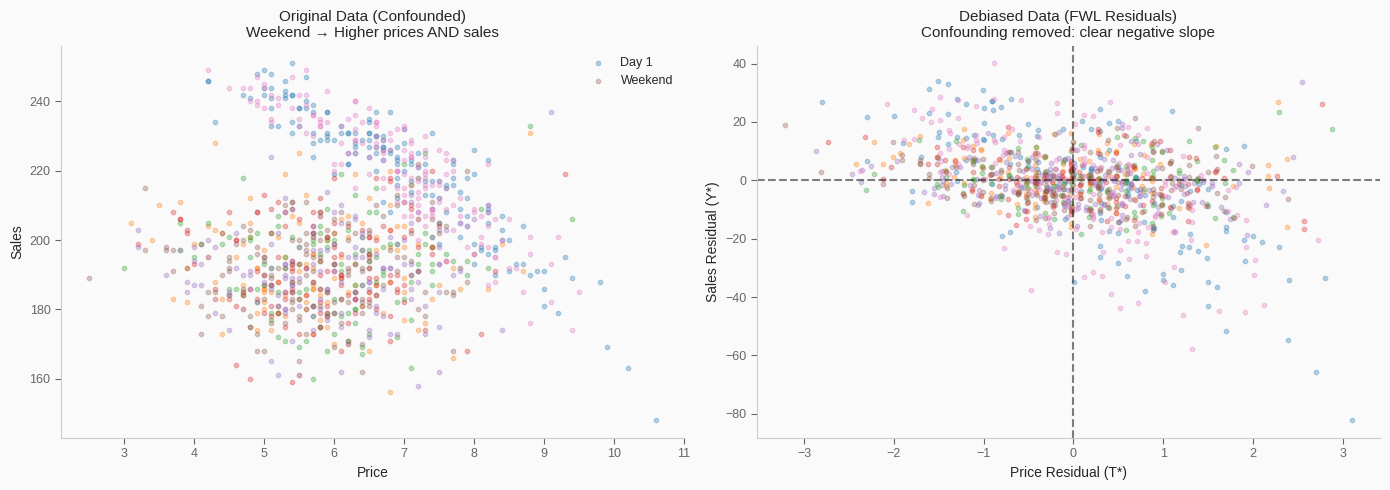

In [7]:
# Compare original vs debiased data
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original: confounded
ax = axes[0]
sample = prices.sample(1000, random_state=42)
for wd in sorted(prices['weekday'].unique()):
    wd_data = sample[sample['weekday'] == wd]
    label = 'Weekend' if wd >= 5 else f'Day {wd}'
    ax.scatter(wd_data['price'], wd_data['sales'], alpha=0.3, s=10, label=label if wd in [1, 6] else None)
ax.set_xlabel('Price')
ax.set_ylabel('Sales')
ax.set_title('Original Data (Confounded)\nWeekend → Higher prices AND sales')
ax.legend()
apply_tufte_style(ax)

# Debiased: residualized
ax = axes[1]
residual_sample = pd.DataFrame({
    'T_star': T_star.iloc[sample.index],
    'Y_star': Y_star.iloc[sample.index],
    'weekday': sample['weekday'].values
})
for wd in sorted(prices['weekday'].unique()):
    wd_data = residual_sample[residual_sample['weekday'] == wd]
    ax.scatter(wd_data['T_star'], wd_data['Y_star'], alpha=0.3, s=10)
ax.axvline(0, color='black', linestyle='--', alpha=0.5)
ax.axhline(0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('Price Residual (T*)')
ax.set_ylabel('Sales Residual (Y*)')
ax.set_title('Debiased Data (FWL Residuals)\nConfounding removed: clear negative slope')
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

In [8]:
# Correlations in debiased data
print("Original correlations:")
print(f"  Corr(price, sales) = {prices['price'].corr(prices['sales']):.4f}")
print(f"  Corr(weekday, price) = {prices['weekday'].corr(prices['price']):.4f}")

print("\nDebiased correlations:")
print(f"  Corr(T*, Y*) = {T_star.corr(Y_star):.4f}  ← Now NEGATIVE!")
print(f"  Corr(weekday, T*) = {prices['weekday'].corr(T_star):.6f}  ← Near zero")

Original correlations:
  Corr(price, sales) = 0.0755
  Corr(weekday, price) = 0.0046

Debiased correlations:
  Corr(T*, Y*) = -0.3423  ← Now NEGATIVE!
  Corr(weekday, T*) = 0.000000  ← Near zero


```
★ Insight ─────────────────────────────────────────────────────
FWL reveals what regression is actually doing:

1. **Debiasing T**: Remove confounder influence from treatment
   - T* = T - E[T|X] has no correlation with X
   - T* is "as-if-random" variation

2. **Denoising Y**: Remove confounder influence from outcome
   - Y* = Y - E[Y|X] has reduced variance
   - Easier to see treatment effect

3. **Estimating**: Simple regression of Y* on T*
   - Only the "clean" variation remains
   - Coefficient = causal effect (under CIA)
──────────────────────────────────────────────────────────────
```

---

## 4. Implementation {#implementation}

### Residual Maker Matrix

In [9]:
def residual_maker(X):
    """Compute the residual maker (annihilator) matrix.
    
    M = I - X(X'X)^{-1}X'
    
    For any vector v: Mv gives the residuals from regressing v on X.
    """
    X = np.asarray(X)
    n = X.shape[0]
    I = np.eye(n)
    # Add constant if not present
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    X_with_const = np.column_stack([np.ones(n), X])
    M = I - X_with_const @ np.linalg.inv(X_with_const.T @ X_with_const) @ X_with_const.T
    return M

# Demonstration on simple data
np.random.seed(42)
n = 100
X = np.random.randn(n)
Y = 2 + 3*X + np.random.randn(n)

M = residual_maker(X)
Y_resid_matrix = M @ Y

# Compare to statsmodels
Y_resid_sm = smf.ols("Y ~ X", data=pd.DataFrame({'X': X, 'Y': Y})).fit().resid

print("Residual maker verification:")
print(f"  Max difference from statsmodels: {np.max(np.abs(Y_resid_matrix - Y_resid_sm)):.2e}")
print(f"  ✓ Residual maker produces correct residuals")

Residual maker verification:
  Max difference from statsmodels: 5.33e-15
  ✓ Residual maker produces correct residuals


### FWL Function

In [10]:
def fwl_coefficient(Y, T, X):
    """Compute coefficient on T using FWL decomposition.
    
    This is equivalent to the coefficient from:
        Y ~ T + X
    
    But computed via residualization.
    
    Parameters
    ----------
    Y : array-like
        Outcome variable
    T : array-like  
        Treatment variable
    X : array-like
        Control variables
        
    Returns
    -------
    float
        Coefficient on T
    """
    Y, T, X = np.asarray(Y), np.asarray(T), np.asarray(X)
    
    # Residual maker for X
    M = residual_maker(X)
    
    # Residualize Y and T
    Y_star = M @ Y
    T_star = M @ T
    
    # Regress Y* on T*
    beta = np.sum(T_star * Y_star) / np.sum(T_star**2)
    
    return beta

# Verify on ice cream data
X_controls = prices[['cost', 'temp']].values  # Simplified for demo
beta_fwl_func = fwl_coefficient(prices['sales'].values, prices['price'].values, X_controls)

# Compare to statsmodels
sm_model = smf.ols("sales ~ price + cost + temp", data=prices).fit()

print(f"FWL function: {beta_fwl_func:.6f}")
print(f"statsmodels:  {sm_model.params['price']:.6f}")
print(f"Difference:   {abs(beta_fwl_func - sm_model.params['price']):.2e}")

FWL function: 1.593042
statsmodels:  1.593042
Difference:   3.66e-14


```
★ Key Takeaway ────────────────────────────────────────────────
FWL provides the theoretical foundation for:

1. **Double/Debiased ML (DML)**: Replace linear residualization with ML
2. **Partial regression plots**: Visualize coefficient relationships
3. **Understanding control variables**: What "controlling for" means
4. **Cross-fitting**: Why sample splitting is necessary for ML

The next notebooks extend FWL to nonparametric settings.
──────────────────────────────────────────────────────────────
```

---

## 5. Interview Appendix {#interview}

### Q1: State the Frisch-Waugh-Lovell theorem and explain its significance.

<details>
<summary>Solution</summary>

**Statement**: For regression $Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \epsilon$:

$$\hat{\beta}_2 = (X_2' M_1 X_2)^{-1} X_2' M_1 Y$$

where $M_1 = I - X_1(X_1'X_1)^{-1}X_1'$ is the residual maker.

**Equivalently**: $\hat{\beta}_2$ from the full regression equals the coefficient from:
1. Regress Y on X₁, get residuals Y*
2. Regress X₂ on X₁, get residuals X₂*
3. Regress Y* on X₂*

**Significance**:
1. Shows what regression actually does to estimate coefficients
2. Reveals "controlling for" as residualization
3. Foundation for Double/Debiased ML
4. Enables nonparametric extensions (replace OLS with ML)

</details>

### Q2: Why do we residualize both Y AND T? Isn't residualizing T enough?

<details>
<summary>Solution</summary>

**Residualizing T** (debiasing):
- Removes confounding from treatment
- Creates "as-if-random" treatment variation
- **This is necessary for identification**

**Residualizing Y** (denoising):
- Removes variance in Y explained by controls
- Reduces residual variance
- **This improves precision but isn't necessary for unbiasedness**

**Mathematical proof**:
- If we only residualize T: $\hat{\beta} = \frac{\text{Cov}(Y, T^*)}{\text{Var}(T^*)}$
- With both residualized: $\hat{\beta} = \frac{\text{Cov}(Y^*, T^*)}{\text{Var}(T^*)}$
- These are equal! But $\text{Var}(Y^*) < \text{Var}(Y)$, so SE is lower.

</details>

### Q3: How does FWL relate to omitted variable bias?

<details>
<summary>Solution</summary>

**Without FWL (omitting X₁)**:
$$\hat{\beta}_2^{\text{short}} = \beta_2 + \gamma \cdot \delta$$
where $\delta = \text{Cov}(X_1, X_2)/\text{Var}(X_2)$

**With FWL**:
- Residualization removes X₁'s influence from X₂
- $X_2^* = X_2 - E[X_2|X_1]$ is orthogonal to X₁
- Hence $\delta^* = 0$ (no omitted variable bias)

**Key insight**: FWL achieves control by orthogonalization.
- We don't need X₁ in the final regression
- Its influence has been "projected out"
- This is what "controlling for" fundamentally means

</details>

### Q4: Explain why FWL is the foundation for Double ML.

<details>
<summary>Solution</summary>

**FWL insight**: Coefficient estimation can be decomposed into:
1. Predict Y from X → get Y residuals
2. Predict T from X → get T residuals
3. Regress Y residuals on T residuals

**Double ML extension**:
- Replace linear predictions with ML models
- Use flexible estimators (forests, neural nets)
- Handle high-dimensional, nonlinear confounding

**Why it works**:
- ML estimates $E[Y|X]$ and $E[T|X]$ nonparametrically
- Residuals are still valid for causal estimation
- Neyman orthogonality protects against ML bias

**Critical requirement**: Cross-fitting to avoid overfitting

</details>

### Q5: What is the "residual maker" or "annihilator" matrix?

<details>
<summary>Solution</summary>

**Definition**:
$$M_X = I - X(X'X)^{-1}X' = I - P_X$$

where $P_X = X(X'X)^{-1}X'$ is the projection (hat) matrix.

**Properties**:
1. $M_X \cdot v$ = residuals from regressing v on X
2. $M_X^2 = M_X$ (idempotent)
3. $M_X X = 0$ (annihilates X)
4. $\text{rank}(M_X) = n - p$ (dimension reduction)

**Geometric interpretation**:
- $P_X$ projects onto column space of X
- $M_X$ projects onto orthogonal complement
- Residuals lie in the null space of X'

**Use in FWL**:
$$\hat{\beta}_2 = (X_2' M_1 X_2)^{-1} X_2' M_1 Y$$

We're regressing M₁Y on M₁X₂ (both projected orthogonal to X₁).

</details>

---

## 6. References {#references}

[^1]: Frisch, R., & Waugh, F. V. (1933). Partial Time Regressions as Compared with
      Individual Trends. *Econometrica*, 1(4), 387-401.

[^2]: Lovell, M. C. (1963). Seasonal Adjustment of Economic Time Series and Multiple
      Regression Analysis. *Journal of the American Statistical Association*, 58(304), 993-1010.

[^3]: Facure, M. (2022). *Causal Inference for the Brave and True*, Appendix:
      Debiasing with Orthogonalization.